# Hyperparameter Tuning with Optuna

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thawn/ttt-workshop-cnn/blob/main/book/pair_programming/optuna_tuning.ipynb)

Note: this notebook requires a GPU. Please switch to T4 GPU using the drop down menu in the top right of the colab interface:

![switch to GPU](assets/change_runtime.png)

## Tune learning rate, weight decay, and channels on a toy training loop

### Install and import dependencies

In [1]:
# Dependency management
import sys, subprocess
for p in ['optuna', 'plotly', 'scikit-learn', 'torch']:
    try:
        __import__(p if p != 'scikit-learn' else 'sklearn')
    except Exception:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', p, '-q'])

In [2]:
from pathlib import Path
import torch, torch.nn as nn, torch.optim as optim
import optuna
import plotly.io as pio

# fix random seeds for reproducibility
torch.random.manual_seed(0)

# set device
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else device  ## Mac OS metal
print(f"Using device: {device}")

# set plotly to render SVGs for display in the Jupyter book
if 'svg' in pio.renderers:
    pio.renderers.default = "svg"

Using device: mps


### Data Model and Loss function

We define some toy data, a simple model and loss function. Which we can then optimize.

In [3]:
# Data
X = torch.randn(64,1,16,16)
y = torch.randn(64,1,16,16)

# Model
class Tiny(nn.Module):
    def __init__(self, ch=8):
        super().__init__()
        self.net = nn.Sequential(nn.Conv2d(1,ch,3,padding=1), nn.ReLU(), nn.Conv2d(ch,1,3,padding=1))
    def forward(self,x): return self.net(x)

# Loss
criterion = nn.MSELoss()


### Define the objective function

We define an objective function. Optuna will optimize its return value. The function takes a trial object as input, which is used to suggest hyperparameters. In this example, we will tune the learning rate, weight decay, and number of channels in a simple neural network.

In [4]:
def objective(trial):
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    wd = trial.suggest_float('weight_decay', 0.0, 1e-3)
    ch = trial.suggest_categorical('channels', [4,8,16,32])
    model = Tiny(ch)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    for _ in range(10):
        opt.zero_grad(); loss = criterion(model(X), y); loss.backward(); opt.step()
    return float(loss)

### Create a study

Here we create a study object, which will manage the optimization process. We specify that we want to minimize the objective function.

By saving the study to a SQLite database, we can easily resume the optimization process later if needed. Thereby, we can add more trials without losing previous results, which means our new trials will be run with hyperparameters closer to the optimum.

By setting the direction to "minimize", we indicate that we want to find the hyperparameters that result in the lowest value of the objective function.

In [5]:
study_name = "tiny_optuna_study"

db_path = Path('data') / f"{study_name}.db"
db_path.parent.mkdir(parents=True, exist_ok=True)

study = optuna.create_study(
    direction="minimize", study_name=study_name, storage=f"sqlite:///{db_path}", load_if_exists=True
)

[I 2025-09-18 16:57:55,138] Using an existing study with name 'tiny_optuna_study' instead of creating a new one.


### Optimize the study

This will run the optimization process for a specified number of trials. Each trial will call the objective function with different hyperparameters suggested by Optuna.

Optuna will keep track of the results and will choose hyperparameters close to the best hyperparameters found so far. Thereby, we do a form of gradient descent in hyperparameter space.


In [6]:
study.optimize(objective, n_trials=30)
print('Best:', study.best_params)

/var/folders/8s/7jr95f1d28vflnwm1cfqv7t40000gr/T/ipykernel_16346/1785795861.py:9: UserWarning:

Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)

[I 2025-09-18 16:57:55,661] Trial 180 finished with value: 1.0023503303527832 and parameters: {'lr': 0.006057775760858208, 'weight_decay': 0.000751040066148466, 'channels': 8}. Best is trial 139 with value: 0.9939734935760498.
[I 2025-09-18 16:57:55,726] Trial 181 finished with value: 1.0007994174957275 and parameters: {'lr': 0.009059817748544932, 'weight_decay': 0.0006961055183184683, 'channels': 8}. Best is trial 139 with value: 0.9939734935760498.
[I 2025-09-18 16:57:55,790] Trial 182 finished with value: 0.994810163974762 and parameters: {'lr': 0.00933784340257503, 'weight_decay': 0.0007341604393412627, 'channels': 8}. Best is trial

Best: {'lr': 0.009179284122480527, 'weight_decay': 0.0006949097213601208, 'channels': 8}


## Evaluate and visualize the results

After the optimization is complete, we can evaluate and visualize the results using `optuna.visualization` module. Here are some common visualizations:

### Plot optimization history

From the history plot, we can see how the objective value (e.g., validation loss) changes over the trials. This helps us understand the convergence behavior of the optimization process. We clearly see that the objective value decreases over time, indicating that the optimization is effectively finding better hyperparameters.

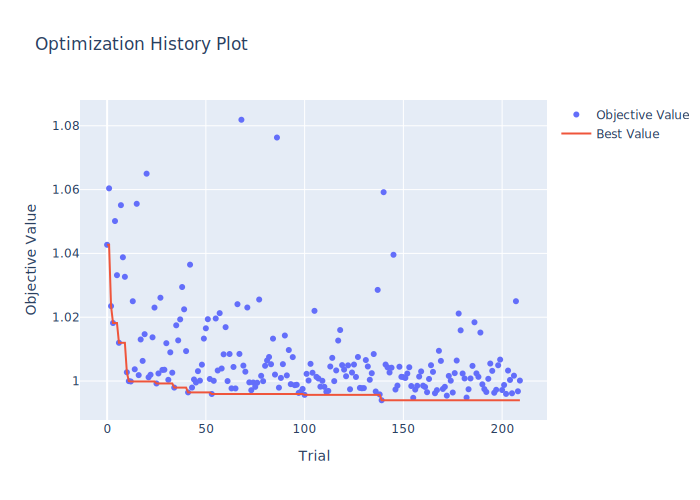

In [7]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

### Hyperparameter importance

The hyperparameter importance plot shows the relative importance of each hyperparameter in determining the objective value. This can help us identify which hyperparameters have the most significant impact on model performance. In this case, we can see that the learning rate has the highest importance, followed by number of channels and weight decay.

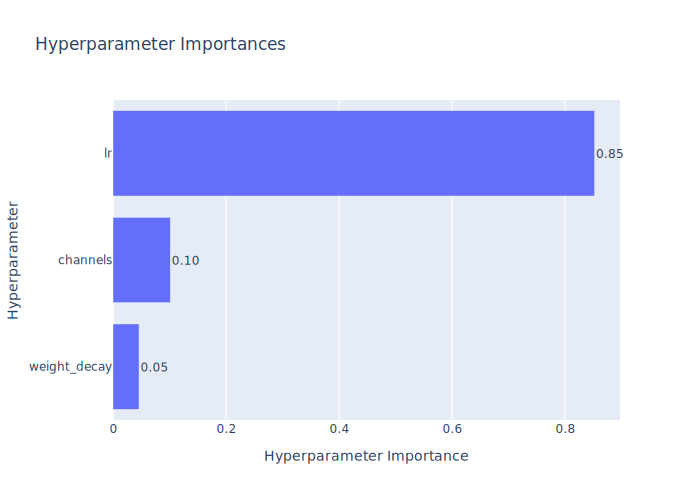

In [8]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

### Parallel coordinate plot

The parallel coordinate plot visualizes the relationship between hyperparameters and the objective value. Each line represents a trial, and we can see how different hyperparameter values correspond to different objective values. This can help us identify patterns and interactions between hyperparameters. For example, we can see that lower learning rates tend to result in lower objective values, especially when combined with higher number of channels.

Darker lines indicate better performance (in our case lower objective values).

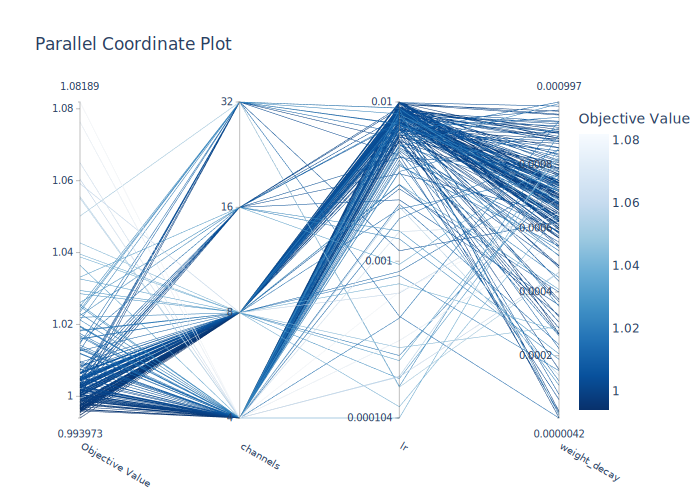

In [9]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.show()

### Slice plot

The slice plot shows the distribution of objective values for each hyperparameter. This can help us understand how sensitive the objective value is to changes in each hyperparameter. For example, we can see that the learning rate has a wide range of objective values, indicating that it is a sensitive hyperparameter. In contrast, weight decay has a narrower range of objective values, suggesting that it is less sensitive.

Also, this helps to identify good ranges for hyperparameters. For example, we can see that the best learning rates are close to our limit of 0.01. This means, we should probably increase the upper limit and run some more trials.

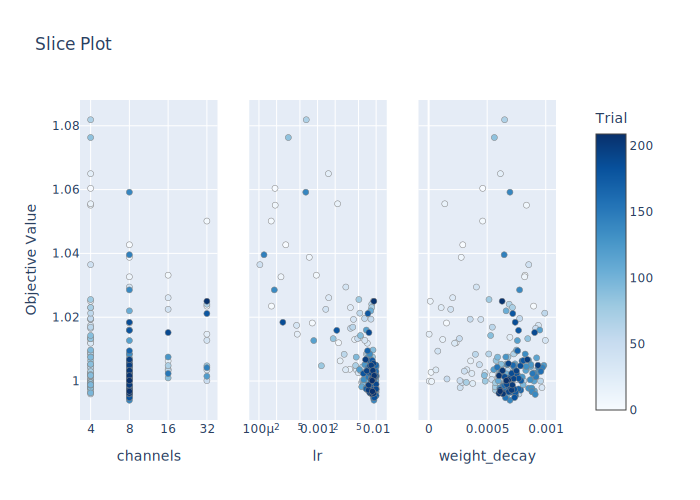

In [10]:
fig = optuna.visualization.plot_slice(study)
fig.show()

## Summary

With optuna, we have a powerful and flexible tool for hyperparameter optimization. By defining an objective function and using various visualization techniques, we can effectively tune our models to achieve better performance.

The hardest part usually is to adapt your model to change its architecture based on the hyperparameters suggested by optuna. But once that is done, you can easily run many trials and find good hyperparameters.

## Exercise

Use optuna to optimize the U-Net in the [U-Net notebook](https://colab.research.google.com/github/thawn/ttt-workshop-cnn/blob/main/book/pair_programming/unet_bbbc039_pair_programming.ipynb). 

Do not forget to add the dependencies and then **restart the notebook**.

Note: you need to shut down the kernel of this notebook before running the U-Net notebook, otherwise google colab will complain about too many open sessions.

## Challenge

Can you beat the best manual tuning?

Which team gets the best test score using optuna?